# Computing the instanton of the Genetic Switch system

Ref: *D. M. Roma, R. A. O'Flanagan, A. E. Ruckenstein, A. M. Sengupta, and R. Mukhopadhyay, Physical Review E 71 , 011902 (2005)*

## Import statements

In [1]:
# Modify path environment variables to search for the local Pyritz installation in the repository.

import os, sys

pyritz_dir = "/".join(os.getcwd().split("/")[:-1])
sys.path.insert(0, pyritz_dir)

# Import statements

import pyritz
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import nlopt

## Define system

#### System:

$$
dX = a(X)dt + \sqrt{\epsilon} dW.
$$

where

$$
a(x_1, x_2) =
\begin{pmatrix}
\frac{c_1}{1 + \left(\frac{x_2}{K_2}\right)^{n} } - \frac{x_1}{\tau} \\
\frac{c_2}{1 + \left(\frac{x_1}{K_1}\right)^{m} } - \frac{x_2}{\tau}
\end{pmatrix}
$$

and

$$
\nabla a = \begin{pmatrix}
    -\frac{1}{\tau} & - \frac{ m a_2 \left(\frac{x_1}{K_1}\right)^m }{x_1 \left(1 + \left(\frac{x_1}{K_1}\right)^m \right)^2} \\
    - \frac{ n a_1 \left(\frac{x_2}{K_2}\right)^n }{x_2 \left(1 + \left(\frac{x_2}{K_2}\right)^n \right)^2} & -\frac{1}{\tau}
\end{pmatrix}
$$

where $(\nabla a)_{ij} = \frac{\partial a_i}{\partial x_j}$.

#### Lagrangian:

$$
L(x, x') = |x'| |a(x)| - x' \cdot a(x)
$$

#### Derivatives of the Lagrangian:

$$
\begin{aligned}
\frac{\partial L}{\partial x_i} & = \sum_{j=1}^{\text{dim}} \left[ \nabla_i a_j( x ) \cdot \left( |\dot x| \hat{a}_j(x) - \dot x_j \right) \right] \\
\frac{\partial L}{\partial x'_i} & = |a(x)| \hat{x}'_i - a_i(x)
\end{aligned}
$$

In [2]:
# System parameters

m_beta = 10

# Fixed points

m_c1 = 156
m_c2 = 30
m_tau = 1; m_rtau = 1/m_tau
m_K1 = 1; m_rK1 = 1/m_K1
m_K2 = 1; m_rK2 = 1/m_K2
m_n = 3
m_m = 1

e_xs = np.array([12.170789373285576, 2.277767804794527])
e_xa = np.array([154.89618053594276, 0.19243576011205307])
e_xb = np.array([0.005880077964304445, 29.824628857064173])

# System Lagrangian

def system_a(xs):
    x1, x2 = xs
    return np.array([m_c1/(1 + np.power(( x2 * m_rK2 ), m_n)) - x1 * m_rtau,
                     m_c2/(1 + np.power(( x1 * m_rK1 ), m_m)) - x2 * m_rtau])

def lagrangian(ls, dxls, dvls, path, us, args):
    xs, vs = path
    
    sas = system_a(xs)
    v_norms = np.linalg.norm(vs, axis=0)
    sa_norms = np.linalg.norm(sas, axis=0)
    vs_dot_sas = np.einsum("ij,ij->j", vs, sas)
    
    ls[:] = v_norms * sa_norms - vs_dot_sas
    
    if not dxls is None:

        ## Compute dL/dx

        da = np.zeros( (xs.shape[0], xs.shape[0], dxls.shape[1]) )
        da[0,0, :] = da[1,1, :] = -m_rtau
        da[0,1, :] = - (m_m*m_c2*np.power( xs[0,:] * m_rK1, m_m ))/( xs[0,:]*(( 1 + np.power(xs[0,:]*m_rK1,m_m) )**2))
        da[1,0, :] = - (m_n*m_c1*np.power( xs[1,:] * m_rK2, m_n ))/( xs[1,:]*(( 1 + np.power(xs[1,:]*m_rK2,m_n) )**2))

        f = np.where(sa_norms!=0)
        sa_units = np.zeros(sas.shape)
        sa_units[:, f] = sas[:, f]/sa_norms[f]

        dxls[:] = np.einsum("jki,ki->ji", da, v_norms*sa_units - vs)

        ## Compute dL/dv

        f = np.where(v_norms!=0)
        avs = np.zeros(vs.shape)
        avs[:, f] = vs[:, f]*sa_norms[f]/v_norms[f]

        dvls[:] = avs - sas

## Computing the instanton

### Gradient-based optimisation

In [3]:
x1 = e_xa
x2 = e_xs

n = 8
nq = n*10

action = pyritz.interpolation.Action(lagrangian, n, nq, x1, x2)
alpha0 = pyritz.interpolation.utils.linear_path(x1, x2, n)

opt = nlopt.opt(nlopt.LD_SLSQP, np.size(alpha0))
opt.set_min_objective(action.compute)
opt.set_xtol_rel(1e-16)
alpha = opt.optimize(alpha0)

print("S[alpha0] = %s" % action.compute(alpha0))
print("S[alpha]  = %s" % action.compute(alpha))

S[alpha0] = 236.76878446820098
S[alpha]  = 4.168254203953991


#### Instanton plot

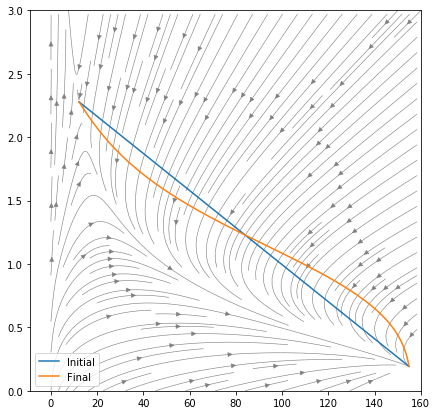

In [4]:
us = np.linspace(-1, 1, 1000)

paths = [
    (action.get_full_alpha(alpha0), "Initial"),
    (action.get_full_alpha(alpha), "Final")
]

for _alpha, _label in paths:
    xs = pyritz.interpolation.utils.interpolate(_alpha, n, us)
    plt.plot(xs[0,:], xs[1,:], label=_label)

X, Y = np.meshgrid(np.linspace(0, 160, 100), np.linspace(0, 3, 100))
sax,say=system_a([X,Y]);
plt.streamplot(X,Y, sax, say, density=1.7, linewidth=.6, color='gray');
plt.legend()

fig = mpl.pyplot.gcf()
fig.set_size_inches(7, 7)

### Gradient-free optimisation

In [5]:
x1 = e_xa
x2 = e_xs

n = 8
nq = n*10

action = pyritz.interpolation.Action(lagrangian, n, nq, x1, x2)
alpha0 = pyritz.interpolation.utils.linear_path(x1, x2, n)

opt = nlopt.opt(nlopt.LN_NEWUOA, np.size(alpha0))
opt.set_min_objective(action.compute)
opt.set_xtol_rel(1e-16)
alpha = opt.optimize(alpha0)

print("S[alpha0] = %s" % action.compute(alpha0))
print("S[alpha]  = %s" % action.compute(alpha))

S[alpha0] = 236.76878446820098
S[alpha]  = 4.1682543778155186


#### Instanton plot

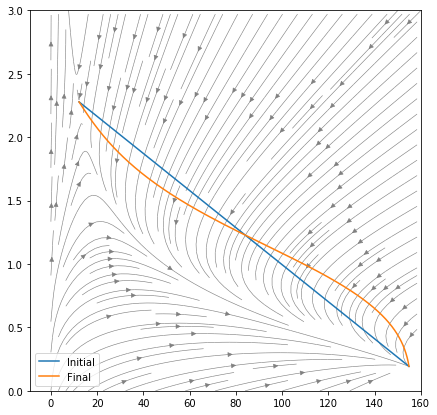

In [6]:
us = np.linspace(-1, 1, 1000)

paths = [
    (action.get_full_alpha(alpha0), "Initial"),
    (action.get_full_alpha(alpha), "Final")
]

for _alpha, _label in paths:
    xs = pyritz.interpolation.utils.interpolate(_alpha, n, us)
    plt.plot(xs[0,:], xs[1,:], label=_label)

X, Y = np.meshgrid(np.linspace(0, 160, 100), np.linspace(0, 3, 100))
sax,say=system_a([X,Y]);
plt.streamplot(X,Y, sax, say, density=1.7, linewidth=.6, color='gray');
plt.legend()

fig = mpl.pyplot.gcf()
fig.set_size_inches(7, 7)